1. Business objective:


To develop a predictive risk scoring pipeline that classifies adverse drug reaction severity using patient age, gender, and medication data. The model generates calibrated probability scores for each severity class and applies a threshold-based rule to identify high-risk cases.



The final dataset is structured for business intelligence visualization and supports risk prioritization and proactive healthcare monitoring.

In [71]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

In [72]:
np.random.seed(42)

n = 100000

drug_list = [
    "Atorvastatin", "Metformin", "Amoxicillin", "Ibuprofen", "Paracetamol",
    "Losartan", "Amlodipine", "Omeprazole", "Azithromycin", "Ciprofloxacin",
    "Warfarin", "Insulin", "Levothyroxine", "Hydrochlorothiazide", "Prednisone"
]

high_risk_drugs = ["Warfarin", "Insulin", "Prednisone"]
moderate_risk_drugs = ["Ciprofloxacin", "Azithromycin"]

adr_terms = [
    "Headache", "Nausea", "Rash", "Dizziness", "Vomiting",
    "Liver Toxicity", "Kidney Injury", "Anaphylaxis",
    "Cardiac Arrest", "Respiratory Failure"
]

def random_date():
    start = datetime(2018, 1, 1)
    end = datetime(2024, 12, 31)
    return start + timedelta(days=random.randint(0, (end - start).days))

data = []

for i in range(1, n+1):
    age = np.random.randint(1, 95)
    drug = np.random.choice(drug_list)

    base_death = 0.01
    base_hosp = 0.10
    base_dis = 0.05

    # Age modifier
    if age >= 65:
        base_death += 0.05
        base_hosp += 0.07
    elif age >= 40:
        base_hosp += 0.03

    # Drug modifier
    if drug in high_risk_drugs:
        base_death += 0.04
        base_hosp += 0.08
    elif drug in moderate_risk_drugs:
        base_hosp += 0.04

    death = np.random.rand() < base_death
    hosp = np.random.rand() < base_hosp
    dis = np.random.rand() < base_dis

    if death:
        severity = "Critical"
    elif hosp:
        severity = "Severe"
    elif dis:
        severity = "Moderate"
    else:
        severity = "Mild"

    data.append([
        i,
        random_date(),
        age,
        np.random.choice(["Male", "Female"]),
        drug,
        np.random.choice(adr_terms),
        death,
        hosp,
        dis,
        severity
    ])

df = pd.DataFrame(data, columns=[
    "CASE_ID", "REPORT_DATE", "PATIENT_AGE", "PATIENT_SEX",
    "DRUG_NAME", "ADVERSE_EVENT",
    "DEATH_FLAG", "HOSPITALIZATION_FLAG", "DISABILITY_FLAG",
    "SEVERITY_LABEL"
])

df.to_csv("enterprise_pv_weighted_dataset.csv", index=False)

In [73]:
df.head()

,CASE_ID,REPORT_DATE,PATIENT_AGE,PATIENT_SEX,DRUG_NAME,ADVERSE_EVENT,DEATH_FLAG,HOSPITALIZATION_FLAG,DISABILITY_FLAG,SEVERITY_LABEL
0,1,2021-01-14,52,Female,Levothyroxine,Rash,False,False,False,Mild
1,2,2024-11-01,87,Male,Warfarin,Liver Toxicity,False,False,False,Mild
2,3,2023-08-30,53,Female,Metformin,Vomiting,False,False,True,Moderate
3,4,2022-03-28,33,Male,Insulin,Respiratory Failure,False,True,True,Severe
4,5,2018-05-14,92,Male,Insulin,Kidney Injury,False,False,False,Mild


STEP 1 — Validate Severity Distribution

In [74]:
df["SEVERITY_LABEL"].value_counts(normalize=True) * 100

,proportion
SEVERITY_LABEL,
Mild,78.097
Severe,14.443
Moderate,4.014
Critical,3.446


STEP 2 — Check Age **Impact**

In [75]:
#Older patients should have higher severe outcomes.

pd.crosstab(
    pd.cut(df["PATIENT_AGE"], bins=[0,40,65,100]),
    df["SEVERITY_LABEL"],
    normalize="index"
) * 100

SEVERITY_LABEL,Critical,Mild,Moderate,Severe
PATIENT_AGE,,,,
"(0, 40]",1.914269,81.937757,4.248972,11.899002
"(40, 65]",1.961600,79.076272,3.911860,15.050268
"(65, 100]",6.820163,71.979850,3.778216,17.421772


**STEP** 3 — **Check** **Drug** **Risk** **Impact**

In [76]:
#High-risk drugs should show higher severity.

pd.crosstab(
    df["DRUG_NAME"],
    df["SEVERITY_LABEL"],
    normalize="index"
) * 100

#warfarin / Insulin / Prednisone

#should show visibly higher Severe/Critical %



SEVERITY_LABEL,Critical,Mild,Moderate,Severe
DRUG_NAME,,,,
Amlodipine,2.683851,80.909780,3.912055,12.494314
Amoxicillin,2.640609,80.859317,4.221990,12.278084
Atorvastatin,2.703519,80.063435,4.183658,13.049388
Azithromycin,2.638992,76.960712,4.255004,16.145293
Ciprofloxacin,2.853781,76.816711,4.192410,16.137099
Hydrochlorothiazide,2.569951,80.185523,4.060219,13.184307
Ibuprofen,2.619188,80.665097,4.046498,12.669217
Insulin,6.790670,70.298199,3.483909,19.427222
Levothyroxine,2.670188,79.973592,4.181338,13.174883


STEP 4 — CDM Data Quality Metrics

In [77]:
print("Missing Age:", df["PATIENT_AGE"].isnull().sum())

Missing Age: 0


In [78]:
print("Missing Sex:", df["PATIENT_SEX"].isnull().sum())

Missing Sex: 0


In [79]:
print("Duplicate Case IDs:", df["CASE_ID"].duplicated().sum())

Duplicate Case IDs: 0


In [80]:
#creating copy of the og dataset for further ammendments
clean_df = df.copy()
print(clean_df.shape)

(100000, 10)


**SEMANTIC** **MODELLING**

STEP 1 — Create Age Bands

In [81]:
clean_df["AGE_GROUP"] = pd.cut(
    clean_df["PATIENT_AGE"],
    bins=[0, 40, 65, 100],
    labels=["Young (<40)", "Middle (40-65)", "Senior (65+)"]
)
#Now you’ve moved from numeric → clinical category.

In [82]:
clean_df.head()

,CASE_ID,REPORT_DATE,PATIENT_AGE,PATIENT_SEX,DRUG_NAME,ADVERSE_EVENT,DEATH_FLAG,HOSPITALIZATION_FLAG,DISABILITY_FLAG,SEVERITY_LABEL,AGE_GROUP
0,1,2021-01-14,52,Female,Levothyroxine,Rash,False,False,False,Mild,Middle (40-65)
1,2,2024-11-01,87,Male,Warfarin,Liver Toxicity,False,False,False,Mild,Senior (65+)
2,3,2023-08-30,53,Female,Metformin,Vomiting,False,False,True,Moderate,Middle (40-65)
3,4,2022-03-28,33,Male,Insulin,Respiratory Failure,False,True,True,Severe,Young (<40)
4,5,2018-05-14,92,Male,Insulin,Kidney Injury,False,False,False,Mild,Senior (65+)


In [83]:
df.head()

,CASE_ID,REPORT_DATE,PATIENT_AGE,PATIENT_SEX,DRUG_NAME,ADVERSE_EVENT,DEATH_FLAG,HOSPITALIZATION_FLAG,DISABILITY_FLAG,SEVERITY_LABEL
0,1,2021-01-14,52,Female,Levothyroxine,Rash,False,False,False,Mild
1,2,2024-11-01,87,Male,Warfarin,Liver Toxicity,False,False,False,Mild
2,3,2023-08-30,53,Female,Metformin,Vomiting,False,False,True,Moderate
3,4,2022-03-28,33,Male,Insulin,Respiratory Failure,False,True,True,Severe
4,5,2018-05-14,92,Male,Insulin,Kidney Injury,False,False,False,Mild


STEP 2 — Create Fatal Case Flag

In [84]:
clean_df["FATAL_CASE"] = clean_df["DEATH_FLAG"].apply(lambda x: "Yes" if x else "No")
#Executives don’t read 0/1. They read Yes/No.
clean_df.head()

,CASE_ID,REPORT_DATE,PATIENT_AGE,PATIENT_SEX,DRUG_NAME,ADVERSE_EVENT,DEATH_FLAG,HOSPITALIZATION_FLAG,DISABILITY_FLAG,SEVERITY_LABEL,AGE_GROUP,FATAL_CASE
0,1,2021-01-14,52,Female,Levothyroxine,Rash,False,False,False,Mild,Middle (40-65),No
1,2,2024-11-01,87,Male,Warfarin,Liver Toxicity,False,False,False,Mild,Senior (65+),No
2,3,2023-08-30,53,Female,Metformin,Vomiting,False,False,True,Moderate,Middle (40-65),No
3,4,2022-03-28,33,Male,Insulin,Respiratory Failure,False,True,True,Severe,Young (<40),No
4,5,2018-05-14,92,Male,Insulin,Kidney Injury,False,False,False,Mild,Senior (65+),No


In [85]:
df.head()

,CASE_ID,REPORT_DATE,PATIENT_AGE,PATIENT_SEX,DRUG_NAME,ADVERSE_EVENT,DEATH_FLAG,HOSPITALIZATION_FLAG,DISABILITY_FLAG,SEVERITY_LABEL
0,1,2021-01-14,52,Female,Levothyroxine,Rash,False,False,False,Mild
1,2,2024-11-01,87,Male,Warfarin,Liver Toxicity,False,False,False,Mild
2,3,2023-08-30,53,Female,Metformin,Vomiting,False,False,True,Moderate
3,4,2022-03-28,33,Male,Insulin,Respiratory Failure,False,True,True,Severe
4,5,2018-05-14,92,Male,Insulin,Kidney Injury,False,False,False,Mild


STEP 3 — Create Severe Case Flag

In [86]:
clean_df["SEVERE_CASE"] = clean_df["SEVERITY_LABEL"].apply(
    lambda x: "Yes" if x in ["Severe", "Critical"] else "No"
)

#Now you can calculate:
#severe Rate
#High-Risk %

clean_df.head()

,CASE_ID,REPORT_DATE,PATIENT_AGE,PATIENT_SEX,DRUG_NAME,ADVERSE_EVENT,DEATH_FLAG,HOSPITALIZATION_FLAG,DISABILITY_FLAG,SEVERITY_LABEL,AGE_GROUP,FATAL_CASE,SEVERE_CASE
0,1,2021-01-14,52,Female,Levothyroxine,Rash,False,False,False,Mild,Middle (40-65),No,No
1,2,2024-11-01,87,Male,Warfarin,Liver Toxicity,False,False,False,Mild,Senior (65+),No,No
2,3,2023-08-30,53,Female,Metformin,Vomiting,False,False,True,Moderate,Middle (40-65),No,No
3,4,2022-03-28,33,Male,Insulin,Respiratory Failure,False,True,True,Severe,Young (<40),No,Yes
4,5,2018-05-14,92,Male,Insulin,Kidney Injury,False,False,False,Mild,Senior (65+),No,No


In [87]:
df.head()

,CASE_ID,REPORT_DATE,PATIENT_AGE,PATIENT_SEX,DRUG_NAME,ADVERSE_EVENT,DEATH_FLAG,HOSPITALIZATION_FLAG,DISABILITY_FLAG,SEVERITY_LABEL
0,1,2021-01-14,52,Female,Levothyroxine,Rash,False,False,False,Mild
1,2,2024-11-01,87,Male,Warfarin,Liver Toxicity,False,False,False,Mild
2,3,2023-08-30,53,Female,Metformin,Vomiting,False,False,True,Moderate
3,4,2022-03-28,33,Male,Insulin,Respiratory Failure,False,True,True,Severe
4,5,2018-05-14,92,Male,Insulin,Kidney Injury,False,False,False,Mild


STEP 4 — Extract Report Year (Trend Analysis)

In [88]:
clean_df["REPORT_YEAR"] = pd.to_datetime(clean_df["REPORT_DATE"]).dt.year
#now you can build yearly trend dashboard.
clean_df.head()

,CASE_ID,REPORT_DATE,PATIENT_AGE,PATIENT_SEX,DRUG_NAME,ADVERSE_EVENT,DEATH_FLAG,HOSPITALIZATION_FLAG,DISABILITY_FLAG,SEVERITY_LABEL,AGE_GROUP,FATAL_CASE,SEVERE_CASE,REPORT_YEAR
0,1,2021-01-14,52,Female,Levothyroxine,Rash,False,False,False,Mild,Middle (40-65),No,No,2021
1,2,2024-11-01,87,Male,Warfarin,Liver Toxicity,False,False,False,Mild,Senior (65+),No,No,2024
2,3,2023-08-30,53,Female,Metformin,Vomiting,False,False,True,Moderate,Middle (40-65),No,No,2023
3,4,2022-03-28,33,Male,Insulin,Respiratory Failure,False,True,True,Severe,Young (<40),No,Yes,2022
4,5,2018-05-14,92,Male,Insulin,Kidney Injury,False,False,False,Mild,Senior (65+),No,No,2018


In [89]:
df.head()

,CASE_ID,REPORT_DATE,PATIENT_AGE,PATIENT_SEX,DRUG_NAME,ADVERSE_EVENT,DEATH_FLAG,HOSPITALIZATION_FLAG,DISABILITY_FLAG,SEVERITY_LABEL
0,1,2021-01-14,52,Female,Levothyroxine,Rash,False,False,False,Mild
1,2,2024-11-01,87,Male,Warfarin,Liver Toxicity,False,False,False,Mild
2,3,2023-08-30,53,Female,Metformin,Vomiting,False,False,True,Moderate
3,4,2022-03-28,33,Male,Insulin,Respiratory Failure,False,True,True,Severe
4,5,2018-05-14,92,Male,Insulin,Kidney Injury,False,False,False,Mild


STEP 5 — Drug Risk Category (Optional but Powerful)

In [90]:
#Let’s classify drugs based on severity rate.

drug_severity_rate = clean_df.groupby("DRUG_NAME")["SEVERE_CASE"].apply(
    lambda x: (x == "Yes").mean()
)

high_risk_drugs = drug_severity_rate[drug_severity_rate > 0.25].index

clean_df["DRUG_RISK_CATEGORY"] = clean_df["DRUG_NAME"].apply(
    lambda x: "High Risk" if x in high_risk_drugs else "Standard Risk"
)
#Now your dataset has business-ready classifications.

In [91]:
clean_df.head(10)

,CASE_ID,REPORT_DATE,PATIENT_AGE,PATIENT_SEX,DRUG_NAME,ADVERSE_EVENT,DEATH_FLAG,HOSPITALIZATION_FLAG,DISABILITY_FLAG,SEVERITY_LABEL,AGE_GROUP,FATAL_CASE,SEVERE_CASE,REPORT_YEAR,DRUG_RISK_CATEGORY
0,1,2021-01-14,52,Female,Levothyroxine,Rash,False,False,False,Mild,Middle (40-65),No,No,2021,Standard Risk
1,2,2024-11-01,87,Male,Warfarin,Liver Toxicity,False,False,False,Mild,Senior (65+),No,No,2024,High Risk
2,3,2023-08-30,53,Female,Metformin,Vomiting,False,False,True,Moderate,Middle (40-65),No,No,2023,Standard Risk
3,4,2022-03-28,33,Male,Insulin,Respiratory Failure,False,True,True,Severe,Young (<40),No,Yes,2022,High Risk
4,5,2018-05-14,92,Male,Insulin,Kidney Injury,False,False,False,Mild,Senior (65+),No,No,2018,High Risk
5,6,2019-09-12,64,Male,Azithromycin,Nausea,False,False,False,Mild,Middle (40-65),No,No,2019,Standard Risk
6,7,2023-10-10,4,Male,Azithromycin,Nausea,False,False,False,Mild,Young (<40),No,No,2023,Standard Risk
7,8,2019-09-25,84,Male,Insulin,Rash,False,True,False,Severe,Senior (65+),No,Yes,2019,High Risk
8,9,2020-08-20,78,Female,Atorvastatin,Liver Toxicity,False,False,False,Mild,Senior (65+),No,No,2020,Standard Risk
9,10,2024-01-26,4,Female,Losartan,Dizziness,False,False,False,Mild,Young (<40),No,No,2024,Standard Risk


In [92]:
df.head()

,CASE_ID,REPORT_DATE,PATIENT_AGE,PATIENT_SEX,DRUG_NAME,ADVERSE_EVENT,DEATH_FLAG,HOSPITALIZATION_FLAG,DISABILITY_FLAG,SEVERITY_LABEL
0,1,2021-01-14,52,Female,Levothyroxine,Rash,False,False,False,Mild
1,2,2024-11-01,87,Male,Warfarin,Liver Toxicity,False,False,False,Mild
2,3,2023-08-30,53,Female,Metformin,Vomiting,False,False,True,Moderate
3,4,2022-03-28,33,Male,Insulin,Respiratory Failure,False,True,True,Severe
4,5,2018-05-14,92,Male,Insulin,Kidney Injury,False,False,False,Mild


MODEL TRAINING

STEP 1 — Prepare Modeling Dataset

will predict:



SEVERITY_LABEL



Using:

PATIENT_AGE

SEX

DRUG_NAME

AGE_GROUP



In [93]:
model_df = clean_df.copy() #creating copy
model_df.head()

,CASE_ID,REPORT_DATE,PATIENT_AGE,PATIENT_SEX,DRUG_NAME,ADVERSE_EVENT,DEATH_FLAG,HOSPITALIZATION_FLAG,DISABILITY_FLAG,SEVERITY_LABEL,AGE_GROUP,FATAL_CASE,SEVERE_CASE,REPORT_YEAR,DRUG_RISK_CATEGORY
0,1,2021-01-14,52,Female,Levothyroxine,Rash,False,False,False,Mild,Middle (40-65),No,No,2021,Standard Risk
1,2,2024-11-01,87,Male,Warfarin,Liver Toxicity,False,False,False,Mild,Senior (65+),No,No,2024,High Risk
2,3,2023-08-30,53,Female,Metformin,Vomiting,False,False,True,Moderate,Middle (40-65),No,No,2023,Standard Risk
3,4,2022-03-28,33,Male,Insulin,Respiratory Failure,False,True,True,Severe,Young (<40),No,Yes,2022,High Risk
4,5,2018-05-14,92,Male,Insulin,Kidney Injury,False,False,False,Mild,Senior (65+),No,No,2018,High Risk


In [ ]:
#First encode categorical variables properly.

from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()

model_df["SEX_ENC"] = le.fit_transform(model_df["PATIENT_SEX"])
model_df["DRUG_ENC"] = le.fit_transform(model_df["DRUG_NAME"])
model_df["AGE_GROUP_ENC"] = le.fit_transform(model_df["AGE_GROUP"])
model_df["TARGET"] = le.fit_transform(model_df["SEVERITY_LABEL"])
#Now dataset is ML-ready.

In [ ]:
model_df.head()

,CASE_ID,REPORT_DATE,PATIENT_AGE,PATIENT_SEX,DRUG_NAME,ADVERSE_EVENT,DEATH_FLAG,HOSPITALIZATION_FLAG,DISABILITY_FLAG,SEVERITY_LABEL,AGE_GROUP,FATAL_CASE,SEVERE_CASE,REPORT_YEAR,DRUG_RISK_CATEGORY,SEX_ENC,DRUG_ENC,AGE_GROUP_ENC,TARGET
0,1,2022-04-08,52,Female,Levothyroxine,Rash,False,False,False,Mild,Middle (40-65),No,No,2022,Standard Risk,0,8,0,1
1,2,2024-07-19,87,Male,Warfarin,Liver Toxicity,False,False,False,Mild,Senior (65+),No,No,2024,High Risk,1,14,1,1
2,3,2020-04-08,53,Female,Metformin,Vomiting,False,False,True,Moderate,Middle (40-65),No,No,2020,Standard Risk,0,10,0,2
3,4,2019-10-26,33,Male,Insulin,Respiratory Failure,False,True,True,Severe,Young (<40),No,Yes,2019,High Risk,1,7,2,3
4,5,2024-06-13,92,Male,Insulin,Kidney Injury,False,False,False,Mild,Senior (65+),No,No,2024,High Risk,1,7,1,1


STEP 2 — Define Features & Target

In [ ]:
X = model_df[[
    "PATIENT_AGE",
    "SEX_ENC",
    "DRUG_ENC",
   "AGE_GROUP_ENC"
]]

y = model_df["TARGET"]

STEP 3 — Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

STEP 4 — Train Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=12,
    random_state=42
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=12, n_estimators=150, random_state=42)

STEP 5 — Evaluate Model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))
#Take screenshot of this output later.

Accuracy: 0.78195

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       697
           1       0.78      1.00      0.88     15639
           2       0.00      0.00      0.00       815
           3       0.00      0.00      0.00      2849

    accuracy                           0.78     20000
   macro avg       0.20      0.25      0.22     20000
weighted avg       0.61      0.78      0.69     20000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


STEP 6 — Confusion Matrix

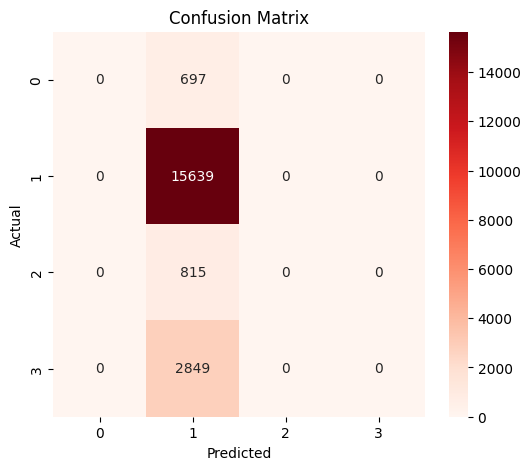

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
#Screenshot this too.

STEP 7 — Feature Importance (Critical for Report)

In [ ]:
import pandas as pd

feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf_model.feature_importances_
})

feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

feature_importance

,Feature,Importance
0,PATIENT_AGE,0.590872
2,DRUG_ENC,0.326739
3,AGE_GROUP_ENC,0.043653
1,SEX_ENC,0.038735


STEP 8 — Visualize Feature Importance

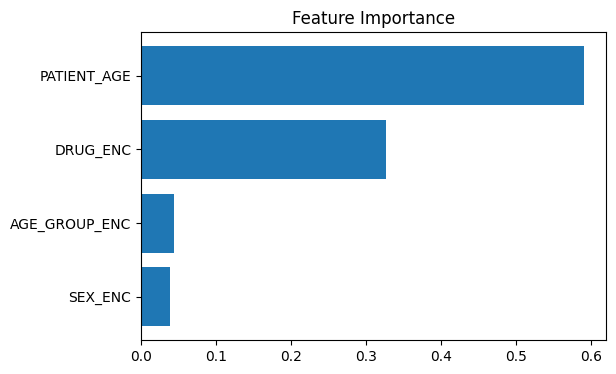

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.show()
#Screenshot this for report.

STEP 9 — Generate Risk Probability Scores

In [ ]:
probabilities = rf_model.predict_proba(X_test)

risk_scores = pd.DataFrame(probabilities)
risk_scores.head()

,0,1,2,3
0,0.205657,0.480301,0.000000,0.314042
1,0.053450,0.758887,0.035886,0.151778
2,0.003261,0.783805,0.058892,0.154042
3,0.015630,0.804294,0.063088,0.116988
4,0.004977,0.825671,0.027407,0.141945


STEP 10 — Create Prescriptive Rule

In [ ]:
risk_scores["High_Risk_Flag"] = (
    probabilities[:, max(range(probabilities.shape[1]))] > 0.75
)

risk_scores.head(20)

,0,1,2,3,High_Risk_Flag
0,0.205657,0.480301,0.000000,0.314042,False
1,0.053450,0.758887,0.035886,0.151778,False
2,0.003261,0.783805,0.058892,0.154042,False
3,0.015630,0.804294,0.063088,0.116988,False
4,0.004977,0.825671,0.027407,0.141945,False
5,0.006177,0.836722,0.041798,0.115303,False
6,0.005549,0.855589,0.031714,0.107148,False
7,0.009367,0.850287,0.040392,0.099954,False
8,0.049806,0.737484,0.046102,0.166608,False
9,0.046765,0.801209,0.051665,0.100361,False


STEP 11 — Attach Risk Scores to Test Dataset

In [ ]:
#First, get probability columns properly labeled.

# Get class labels
class_labels = rf_model.classes_

# Create probability dataframe with proper column names
prob_df = pd.DataFrame(
    probabilities,
    columns=[f"Prob_Class_{c}" for c in class_labels]
)

prob_df.head()

,Prob_Class_0,Prob_Class_1,Prob_Class_2,Prob_Class_3
0,0.205657,0.480301,0.000000,0.314042
1,0.053450,0.758887,0.035886,0.151778
2,0.003261,0.783805,0.058892,0.154042
3,0.015630,0.804294,0.063088,0.116988
4,0.004977,0.825671,0.027407,0.141945


Now attach this to test dataset.

In [ ]:
# Reset index to align
X_test_reset = X_test.reset_index(drop=True)
y_test_reset = y_test.reset_index(drop=True)

export_df = pd.concat([X_test_reset, y_test_reset, prob_df], axis=1)

export_df.head()

,PATIENT_AGE,SEX_ENC,DRUG_ENC,AGE_GROUP_ENC,TARGET,Prob_Class_0,Prob_Class_1,Prob_Class_2,Prob_Class_3
0,2,1,14,2,1,0.205657,0.480301,0.000000,0.314042
1,81,0,11,1,1,0.053450,0.758887,0.035886,0.151778
2,50,0,12,0,1,0.003261,0.783805,0.058892,0.154042
3,26,0,4,2,1,0.015630,0.804294,0.063088,0.116988
4,62,1,3,0,1,0.004977,0.825671,0.027407,0.141945


STEP 12 — Convert Encoded Back to Business Labels (Important for tableau)

In [ ]:
reverse_map = dict(zip(
    model_df["TARGET"],
    model_df["SEVERITY_LABEL"]
))

export_df["ACTUAL_SEVERITY"] = export_df["TARGET"].map(reverse_map)

STEP 13 — Create High Risk Flag (Critical Probability > 0.7)



In [ ]:
#Assuming highest class index corresponds to Critical (verify from class_labels):

critical_index = list(class_labels).index(max(class_labels))

export_df["CRITICAL_PROB"] = prob_df.iloc[:, critical_index]

export_df["HIGH_RISK_FLAG"] = export_df["CRITICAL_PROB"] > 0.25

In [ ]:
export_df = export_df.rename(columns={
    "PATIENT_AGE": "Patient Age",
    "DRUG_ENC": "Drug",
    "SEX_ENC": "Gender",
    "CRITICAL_PROB": "Critical Risk Probability",
    "HIGH_RISK_FLAG": "High Risk"
})

In [ ]:
export_df.head()

,Patient Age,Gender,Drug,AGE_GROUP_ENC,TARGET,Prob_Class_0,Prob_Class_1,Prob_Class_2,Prob_Class_3,ACTUAL_SEVERITY,Critical Risk Probability,High Risk
0,2,1,14,2,1,0.205657,0.480301,0.000000,0.314042,Mild,0.314042,True
1,81,0,11,1,1,0.053450,0.758887,0.035886,0.151778,Mild,0.151778,False
2,50,0,12,0,1,0.003261,0.783805,0.058892,0.154042,Mild,0.154042,False
3,26,0,4,2,1,0.015630,0.804294,0.063088,0.116988,Mild,0.116988,False
4,62,1,3,0,1,0.004977,0.825671,0.027407,0.141945,Mild,0.141945,False


In [ ]:
export_df = export_df[[
    "Patient Age",
    "Gender",
    "Drug",
    "ACTUAL_SEVERITY",
    "Critical Risk Probability",
    "High Risk"
]]

In [ ]:
export_df.head()

,Patient Age,Gender,Drug,ACTUAL_SEVERITY,Critical Risk Probability,High Risk
0,2,1,14,Mild,0.314042,True
1,81,0,11,Mild,0.151778,False
2,50,0,12,Mild,0.154042,False
3,26,0,4,Mild,0.116988,False
4,62,1,3,Mild,0.141945,False


In [ ]:
export_df.to_csv("tableau_risk_output.csv", index=False)

In [ ]:
from google.colab import files
files.download("tableau_risk_output.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Conclusion**



This project successfully developed a machine learning-based healthcare risk scoring system to predict adverse drug reaction severity using patient and medication features. The Random Forest model generated probability scores for each severity class, enabling a risk-based interpretation rather than simple categorical prediction.



By applying a threshold-based rule on the critical probability, high-risk cases were identified in a structured and explainable manner. The final output was transformed into a business-ready dataset, supporting visualization and decision-making.



This pipeline demonstrates how predictive modeling, probability calibration, and rule-based governance can be integrated to support proactive pharmacovigilance and risk prioritization in healthcare systems.